# **Project: Asset Replacement with Maintenance**



   At the beginning of each year, a manufacturer must decide wheter to continue to operate an aging physical asset or replace it with a new one. If he keep the current asset, he must decide whether to perform annual service maintenance to prevent the asset from failing. An asset that is $s$ years old yields a profit contribution $p(s)$ up to $n=5$ years, at which point the asset becomes unsafe and must be replaced by law. An asset that is $s$ years old and has been maintained $m$ times fails with probability $\mu(s,m)$ and yields a proft of 0 in that year. The cost of a new asset is $c = 75$ and the cost of of servicing an asset is $k=10$.

  What replacement-maintenance policy maximizes profits?

# Table of Contents

* [Section 1 Model description](#model)
* [Section 2 Environment](#env)
* [Section 3 Dynamic Programming](#DP)
    * [Section 3.1 Policy evaluation and iteration](#PE&PI)
    * [Section 3.2 Value Iteration](#VI)
    * [Section 3.3 Evaluation of future discount](#Eval1)
    * [Section 3.4 Evaluation of maintenance cost](#Eval1.1)
    * [Section 3.5 Evaluation of replacement cost](#Eval1.2)
* [Section 4 Reinforcement Learning](#RL)    
    * [Section 4.1 Sarsa](#Sarsa)
        * [Section 4.1.1 Evaluation of parameters](#Eval2)
        * [Section 4.1.1 Plot of simulation for best performance](#plot1)
    * [Section 4.2 Q-Learning](#QL)
        * [Section 4.2.1 Evaluation of parameters](#Eval3)
        * [Section 4.2.2 Plot of simulation for best performance](#plot2)
    * [Section 4.3 Expected Sarsa](#ExSa)
        * [Section 4.1.1 Plot of simulation for best performance](#plo3)
* [Section 4 Conclusion](#conclusion)

<a id='model'></a>

# **Model**

This is an infinite horizon deterministic model with time $t$ measured
in years.

The age is a discrete state variable:
- $s \in \{0, 1, 2, 3, 4, 5\}$

The variable $maint$ is the number of times of maintenance habe been performed:
- $m \in \{0, 1, 2, 3, 4, 5 \}$


The action variable $a$ is the keep-replacement-maintenance decision:
- $a =  \begin{cases}
  0,  & \text{ keep the asset, perform no maintenance}\\
  1,  & \text{ keep the asset, perform the maintenace}\\
  2,  & \text{ replace the asset}
  \end{cases}$


The state transition function is:
- $t(s, a) = \begin{cases}
  s+1,  & a = \text{ keep}\\
  1, & a = \text{ replace}
  \end{cases}$
  
The maintenance transition function is:
 - $t(m, a, s) = \begin{cases} 
   m,  & a = 0 ,  \text{keep the asset but perform no maintenance}\\
   m+1,  & a = 1,   \text{keep the asset, perform the maintenac} \\
   0, & a =2,  \text{ replace the asset}
  \end{cases}$
  
 
The reward function is:
- $r(s, a, m) = \begin{cases}
  p(s), & a = 0 ,  \text{keep the asset but perform no maintenance, the asset works}\\
  0, & a = 0 ,  \text{keep the asset but perform no maintenance, the asset fail with the probability of} \mu(s,m)\\
  p(s) - k, &  a = 1,   \text{keep the asset, perform the maintenace,the asset works}\\
  0 - k & a = 1,  \text{keep the asset, perform the maintenace, the asset fails with the probability of} \mu(s,m) \\
  p(0)- c, & a =2,  \text{ replace the asset}
\end{cases}$

where $p(s) = 50 - 2.5\cdot s - 2.5\cdot s^2$. 



**Important Information**
- p(4) = 0, p(s) concave         


- state is the age of the machine, which means it refers to end of that year.   


- We assume that   
    1.when the maitenance is performed and when calculating the probability of fail $\mu(s,m)$, current maintenance is **not considered** to an increase of current *$m$* number of maintenance. We assume the profit is calculated at the end of the year s(at age s), so will the maintenance at this time be performed, although the decision to perform the maintenance has already been made at the beginning of each year according to the project description.  
    It is nature to consider that the asset already fail sometime during the year, which happpened before the maintenance and thus before the calculation of the reward, with the probability of $\mu(s,m)$ that depend on m not m+1. Otherwise, it result in difficuty in modelling and in implemetation, as current state pair, from which the reward is calculated,  would be actually the current age s (before action taked) and next m (after action taken).   
    Anyhow, it is definately possible to solve this problem resulting from ambiguiity by rearrange the environment and logic of iteration carefully. We have tried to think of  $\mu(s,m+1)$ for dynamic programming, since it is quick and easy. The optimal policy won't change, since after all the cost of maintenance is too high. If we could have more time, we would also adapt the implenentation of our reinforcement learning algorithm to it.    
    
    2. The failiure of the machine is regarded as temporary in the modelinng. We had not directly related asset replacement after the machine failure. 


- In this project, the many global variables for different algorithms have the same name and would be overwirrten again and again. If the cells are executed in the nature order, (except from the part that we give warning) then it is fine. If you are now at the end, then want come back to check something, it is necessary to excute the whole relavent block of cells again above the cell you want to check. 

<a name='env'></a>

# **Environment**

In [1]:
import gym
from gym import spaces
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.random import default_rng

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
class AssetReplacementEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(AssetReplacementEnv, self).__init__()

        self.n_actions = 3
        self.action_space = spaces.Discrete(self.n_actions)

        self.n_states = 6
        self.observation_space = spaces.Discrete(self.n_states)

        self.n_maint = 6
        self.maint_space = spaces.Discrete(self.n_maint)
        
        self.service = 10
        self.cost = 75
        self.rng = default_rng()
   


    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

 
    
        # calculate the reward and the state transition
        if action == 2:                                    
            reward = self.profit(0) - self.cost         # replace
            self.state = 1 
            self.maint = 0
            
        elif action == 1:
            reward = self.profit(self.state) - self.service
            self.state += 1
            self.maint += 1 
               
                
        else: 
            reward = self.profit(self.state) 
            self.state += 1    

        return self.state, self.maint, reward



    
    def profit(self, state):
        return 50 - 2.5*state - 2.5*state**2
        

    def reset(self):
        # set initial state (age of machine) to 0
        self.state = 0
        self.maint = 0            
        return self.state, self.maint


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

<a name='DP'></a>

# **Dynamic Programming**
By Dynamic programming, we consider the expectation to iterate the value fucntion, which give us ture/ real optimal policy.
Now instead of  expectation we consider the sampling, which means the value fucntion is explixit calculated from so that the machine is either failed or not or for replacement (as a sample in simulation).

<a name='PE&PI'></a>

## **Policy Evaluation**
We first evaluate the self defined policy.

In [54]:
def evaluate_policy(env, V, policy, discount, eps=1e-8, max_iter=10000):
     
    for i in  range(max_iter):
        V[0,0] =  env.profit(0) + discount* V[1,0]
        V_old = V.copy()
        for state in range(env.n_states):
            for maint in range(env.n_maint):
                if state < maint:
                    break
                else:
                    action = policy[state, maint]
                    if action < 0:
                        break
                    else:
                        env.state = state
                        env.maint = maint
                        state_next, maint_next, reward = env.step(action)
                        if action == 2:
                            V[state, maint] =  reward + discount* V[state_next, maint_next]
                        elif action == 1:
                            mu = (state - maint)/5
                            V[state, maint] = mu*(0 - env.service +  discount* V[state_next, maint_next]) \
                                               +(1 - mu)*(reward + discount* V[state_next, maint_next])
                        else:
                            mu = (state - maint)/5
                            V[state, maint] = mu*(0 +  discount* V[state_next, maint_next]) \
                                               +(1 - mu)*(reward + discount* V[state_next, maint_next])
                                
                                
        # check for convergence
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    print('Convergence at iteration ' + str(i))            
    #print(delta)
    return V


Policy to evaluate: keep the asset without maintenance until year2, perform the maintnenance at year 3&4, replace it at year 5

In [3214]:
policy = np.empty((env.n_states, env.n_maint), int)
policy.fill(-1)
policy[0:3, 0] = 0
policy[3:5, 0] = 1
policy[4,1] = 1
policy[5,0:3] = 2
policy

array([[ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 0, -1, -1, -1, -1, -1],
       [ 1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1],
       [ 2,  2,  2, -1, -1, -1]])

In [366]:
#same as policy1 above as matrix 
# def policy1(state, maint):
#     if state < 2:
#         action = 0
#     elif state == 2:
#         action = 1
#     elif 2 < state < 6:
#         action = 2
#     else:
#         print('state error')
#     return action

In [3215]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# init value function
V = np.zeros((env.n_states, env.n_maint))


# discount factor
discount = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy, discount)


Convergence at iteration 167


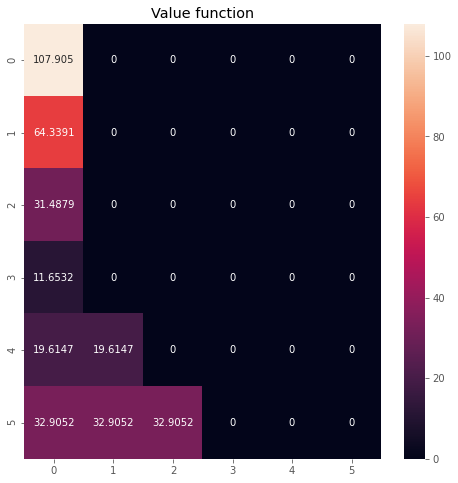

In [3216]:
plt.figure(figsize=(8,8))
#df.shape
sns.heatmap(V, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

## **Policy Iteration**   

We implement the policy improvement algorithm to combine it later with the policy evaluation algorithm to create the policy iteration algorithm.

In [6]:
def improve_policy(env, V, policy, gamma):
    """Implements the policy improvement algorithm

    Calculates the greedy policy for a given value function and checks if the 
    new greedy policy changed compared to the old policy

    Args:
        env (class): OpenAI gym environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (int): Discount factor
    """

    # save policy to check for convergence later
    old_policy = policy.copy()
    policy_stable = True

    # loop through every state and find greedy action
    for state in range(env.n_states):
        for maint in range(env.n_maint):
            if state <= maint:
                break
            elif state== 5:                           
                    policy[state, maint] = 2
            else:
                #Va is actiaully the thrid dimension of  V(value function) indexing by action, but since we just
                #need the maximum value w.r.t. possible action, we take it our as a new vector and declare as va. 
                Va = np.zeros(env.n_actions)
                # find greedy action among possible actions
                for action in range(env.n_actions):
                    env.state = state
                    env.maint = maint
                    #mu  for reward based on current states not next ones
                    mu = (state - maint)/5
                    state_next, maint_next, reward = env.step(action)
                    if action == 2:
                         Va[action] =  reward + discount* V[state_next, maint_next]
                    elif action == 1:
                         Va[action] = mu*(0 - env.service +  discount* V[state_next, maint_next]) \
                                           +(1 - mu)*(reward + discount* V[state_next, maint_next])
                    else:
                         Va[action] = mu*(0 +  discount* V[state_next, maint_next]) \
                                           +(1 - mu)*(reward + discount* V[state_next, maint_next])

                policy[state, maint] =  np.argmax(Va)


    # check for convergence
    if not np.array_equal(policy, old_policy):
        policy_stable = False
    
    return policy, policy_stable


In [7]:
def policy_iteration(env, discount,policy):
    # init value function
    V = np.zeros((env.n_states,env.n_maint))
  
    # iterate until policy doesn't change anymore
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, policy, discount)
        policy, policy_stable = improve_policy(env, V, policy, discount)

    return V, policy

In [3219]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()


# discount factor
discount = 0.9

# use policy defined above as the initial policy
# apply policy iteration
V, policy = policy_iteration(env, discount, policy)

Convergence at iteration 167
Convergence at iteration 96
Convergence at iteration 156
Convergence at iteration 119


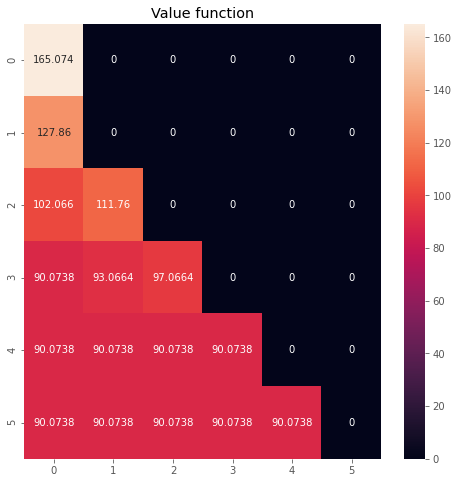

In [3220]:
plt.figure(figsize=(8,8))
sns.heatmap(V, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

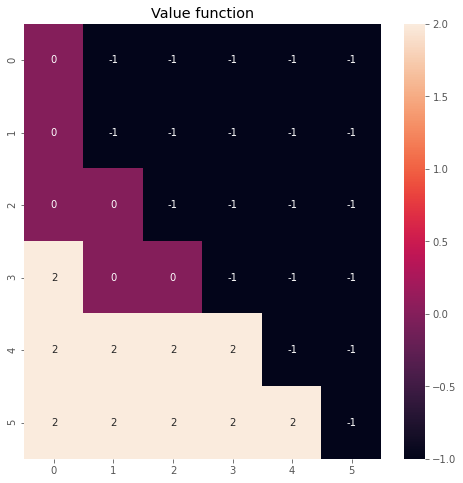

In [3221]:
plt.figure(figsize=(8,8))
sns.heatmap(policy, annot=True, fmt = 'g')
#plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.title('Value function')
plt.show()

<a name='VI'></a>

## **Value Iteration**

In [3]:
def value_iteration(env, discount, eps=1e-8, max_iter= 10000):
    """Implements the value iteration algorithm

    Calculates the optimal policy and optimal value function

    Args:
        env (class): OpenAI gym environment
        discount (float): Discount factor
        eps (float): Error tolerance
        max_iter (int): Maximum number of iteration
    """
    # initialize value function
    V = np.zeros((env.n_states, env.n_maint))
    # initialize policy (of all states) with -1 
    policy = np.zeros((env.n_states, env.n_maint), int)-1
    policy[0,0] = 0
 
    # iterate until value function converges
    for i in range(max_iter):
        V_old = V.copy()
        V[0,0] = env.profit(0) + discount* V[1,0]
        for state in range(env.n_states):
            for maint in range(env.n_maint):
                    if state <= maint:
                        break
                    else:
                        if state == 5:
                            env.state = state
                            env.maint = maint
                            state_next, maint_next, reward = env.step(2)
                            V[state, maint] =  reward + discount* V[state_next, maint_next]
                        else: 
                            #Va is actiaully the thrid dimension of  V(value function) indexing by action, but since we just
                            #need the maximum value w.r.t. possible action, we take it our as a new vector and declare as va. 
                            Va = np.zeros(env.n_actions)
                            # determine possible actions for given state
                            for action in range(env.n_actions):
                                env.state = state
                                env.maint = maint
                                # mu for reward based on curerent states not next ones
                                mu = (state - maint) /5
                                state_next, maint_next, reward = env.step(action)
                                #print((state, maint,state_next, maint_next))
                                if action == 2:
                                    Va[action] =  reward + discount* V[state_next, maint_next]
                                elif action == 1:
                                    Va[action] = mu*(0 - env.service +  discount* V[state_next, maint_next]) \
                                                +(1 - mu)*(reward + discount* V[state_next, maint_next])
                                else:
                                  
                                    Va[action] = mu*(0 +  discount* V[state_next, maint_next]) \
                                                +(1 - mu)*(reward + discount* V[state_next, maint_next])

                            V[state, maint] = max(Va)
                    
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    print('Convergence at iteration: '+str(i))  

    for state in range(env.n_states):
            for maint in range(env.n_maint):
                   if state <= maint:
                        break
                   
                   else: 
                        Va = np.zeros(env.n_actions)
                        if state == 5:                           
                            policy[state, maint] = 2
                        elif state == 0:
                            policy[state, maint] = 0
                        else:    
                            # find greedy action among possible actions
                            for action in range(env.n_actions):
                                env.state = state
                                env.maint = maint
                                # mu for reward based on curerent states not next ones
                                mu = (state - maint) /5
                                state_next, maint_next, reward = env.step(action)
                                #print((state, maint,state_next, maint_next))
                                if action == 2:
                                    Va[action] =  reward + discount* V[state_next, maint_next]
                                elif action == 1:
                                    Va[action] = mu*(0 - env.service +  discount* V[state_next, maint_next]) \
                                                +(1 - mu)*(reward + discount* V[state_next, maint_next])
                                else:
                                    Va[action] = mu*(0 +  discount* V[state_next, maint_next]) \
                                                +(1 - mu)*(reward + discount* V[state_next, maint_next])
                            #print(Va)
                            policy[state, maint] =  np.argmax(Va)
    
    
    
    return V, policy


In [4]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 142


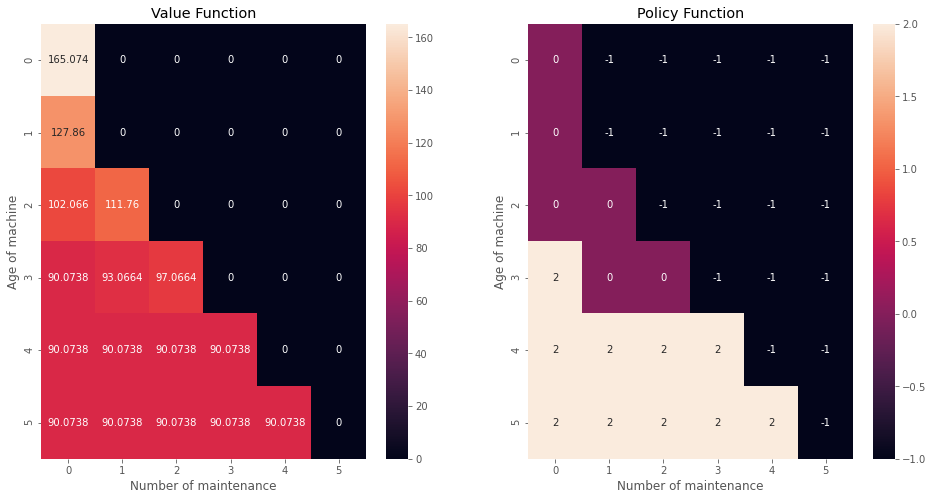

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount) +'.pdf')
plt.show()

Simulate an episode with the optimal policy.

In [5]:
V_DP = V
policy_DP = policy

In [3225]:
# plot the path
#initialization
state, maint = env.reset()
action = policy_DP[state, maint]
state_path = [state]
maint_path = [maint]
action_path = [action]


timesteps = 20
for t in range(timesteps):
    state, maint, reward = env.step(action)
    action = policy_DP[state, maint] 
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)

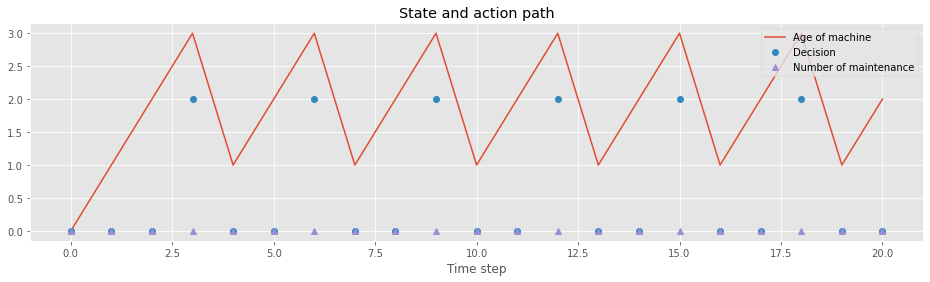

In [2778]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenance')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('DP_Path' + '-'+ str(discount)+'-'+'.pdf')
plt.show()

<a name='Eval1'></a>

---
## **Evaluation of the future discount**
---

Summary: the optimal profit-maximizing policy would change accroding to the future discount. Generally, the less is the future discount, the more possible to keep the asset (at late year without replacing it directly). There are **three** different optimal policy for four cases.      
$\gamma \in [0.9991, 1)$, see plot of $\gamma = 0.9991$. the same as the thrid case.    
$\in [0.85, 0.999)$, see plot of $\gamma = 0.9$ ((in section value iteration). At year = 3, only when maint = 0, the asset should be replaced      
$\in[0.51, 0.85)$ see plot of $\gamma = 0.8$. Asset should be kept without maintenance until be replaced from year 4        
$\in [0, 0.51)$, see plot of $\gamma = 0.5$. Asset can be kept without maintenance u5til year4, then replace at year 5.
         

In [12]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# discount factor
discount = 0.9991

# apply policy iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 9999


I tried to increase the maximal allowed iteration and conclude that there must be no convergence, under this case that disount is too large for convergence. We can actually skip this case, since it might be hard to explain what happened.

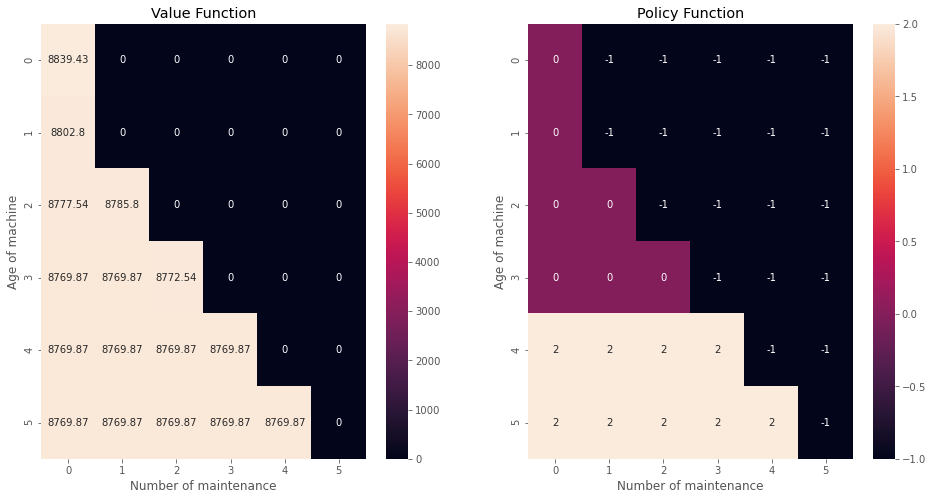

In [3269]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount) +'.pdf')
plt.show()

In [13]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# discount factor
discount = 0.8

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 75


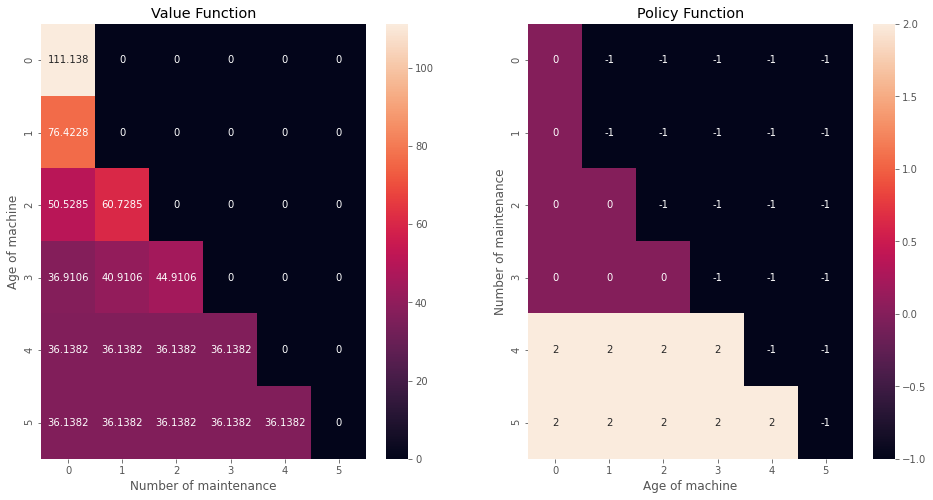

In [3271]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_xlabel('Age of machine')
ax[1].set_ylabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount) +'.pdf')
plt.show()

In [3272]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()

# discount factor
discount = 0.5

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 25


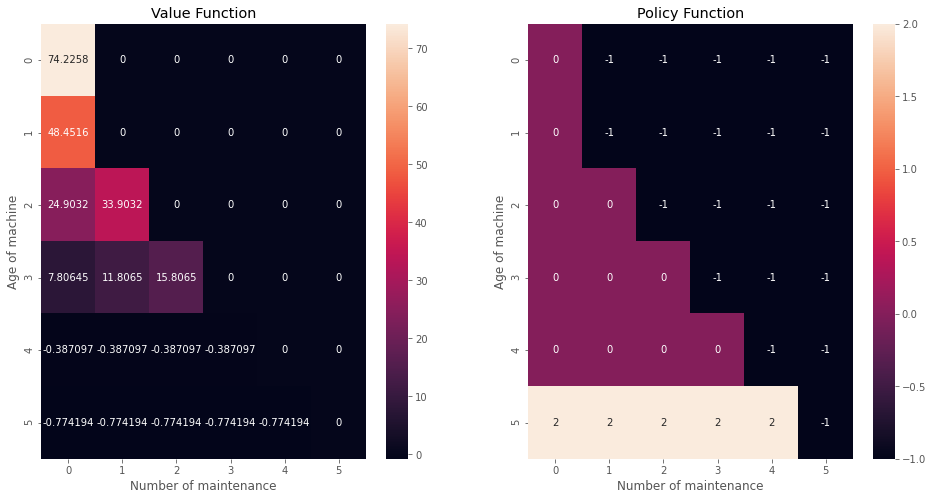

In [3274]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount) +'.pdf')
plt.show()

<a name='Eval1.1'></a>

---
## **Evaluation of the maintenance cost**
---
Summary: the optimal profit-maximizing policy would change accroding to the service(maitenance) cost. When we decrasing the service cost, it is then worthy to perform maintenance at early year. There are three different optimal policy.
 
For about service cost    
$\in [9, \infty)$,  see plot for env.service = 10 (in section value iteration). No maintenance at all.     
$\in [5, 9)$, see plot for env.service = 8. At year1, perform  the maintenance    
$\in (0, 4] $ see plot for  env.service = 3.  At year1 and year2 could perform the maintenance    
        

In [3275]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
env.service = 8

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 159


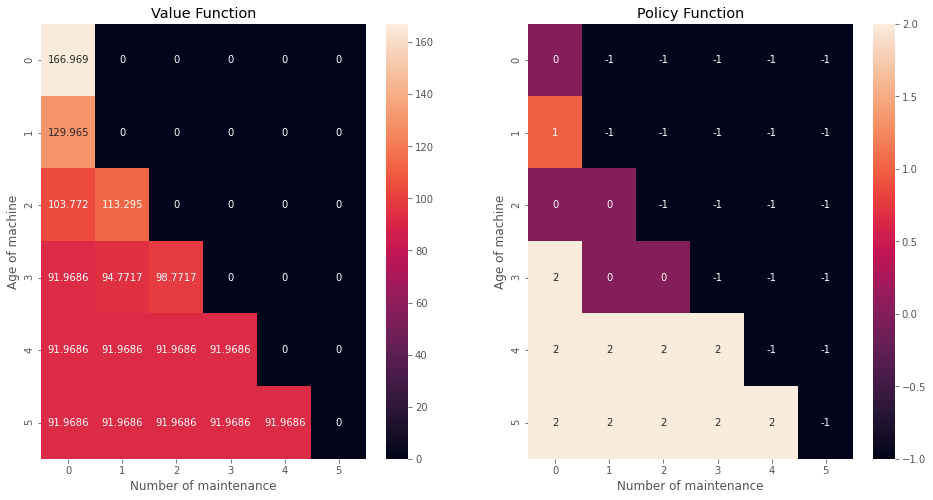

In [3276]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+ '-' +str(env.service)+'.pdf')
plt.show()

In [3277]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
env.service = 3

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 160


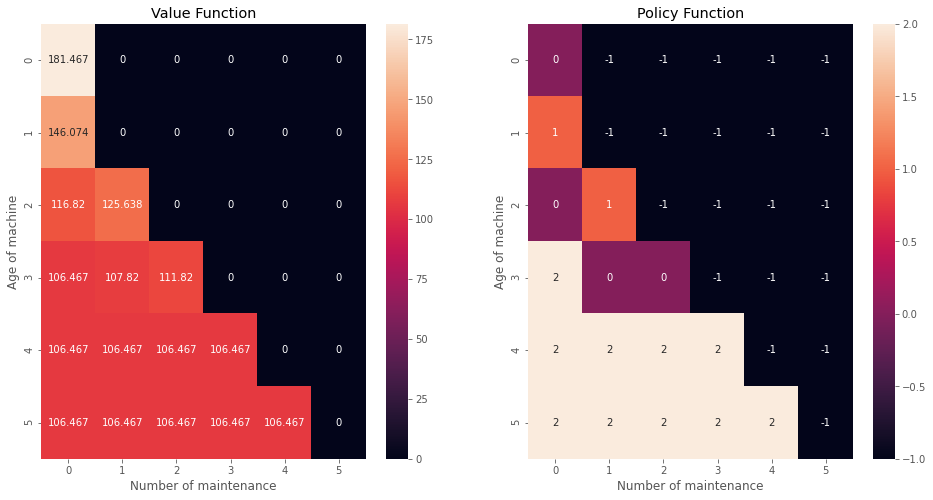

In [3278]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' +str(env.service)+'.pdf')
plt.show()

<a name='Eval1.2'></a>

---
## **Evaluation of the replacement cost**
---
Summary: the optimal profit-maximizing policy would change accroding to the replacement cost. Obviously, the cheaper is the replacement cost, the more possble not to perform maitenance and more possible to directly replace asset at early year. when the cost for replacement is similar as for the maintenance (or less), all action = replace.
There are **six** different optimal policy.

For about replacement cost    
           $\in [112, \infty)$,  see plot for env.cost = 112.    
           $\in [68, 112)$, see plot for env.cost = 75 (in section value iteration) or cost = 68 below     
           $\in [43, 68) $,  see plot for  env.cost = 43.    
           $\in [30, 43) $, see plot for  env.cost = 30.   
           $\in [14, 43) $, see plot for  env.cost = 14.   
           $\in [0, 14) $, see plot for  env.cost = 10.

In [3279]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 112
# the service cost is default 10

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 163


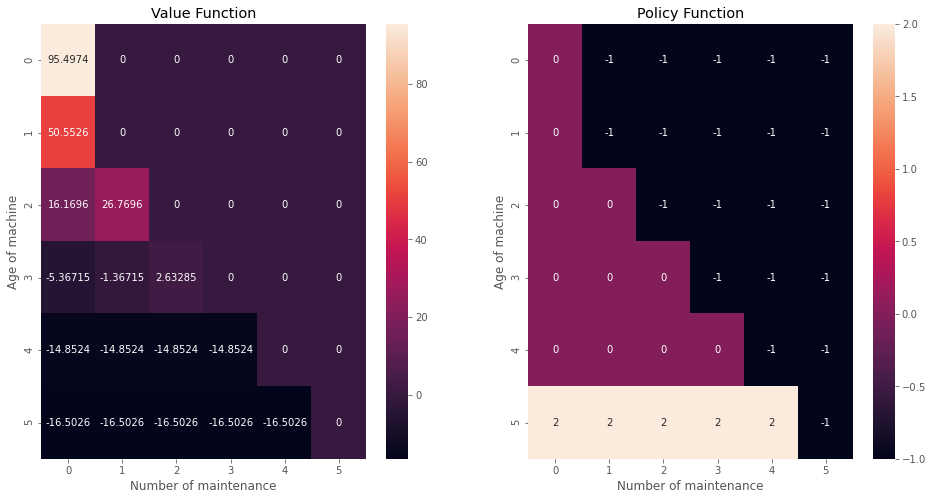

In [3280]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-'+ str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

In [3281]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 68

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 144


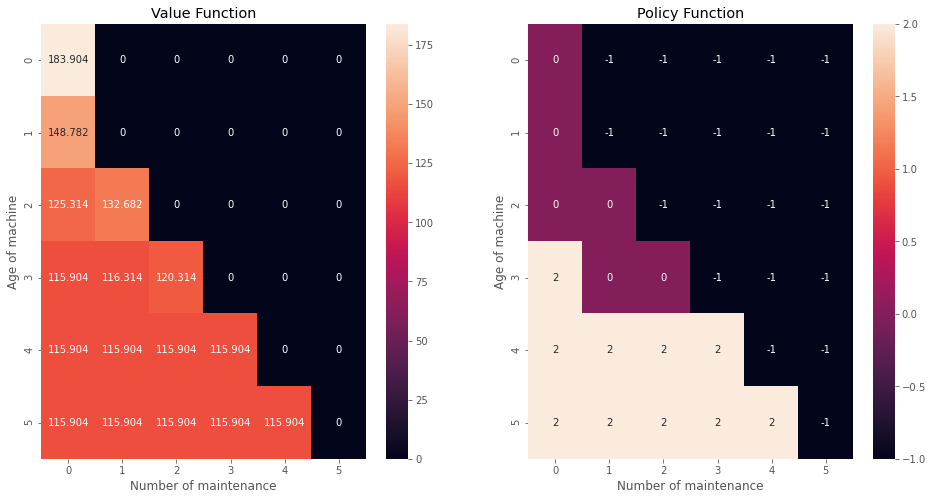

In [3282]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' + str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

In [3283]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 43

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 142


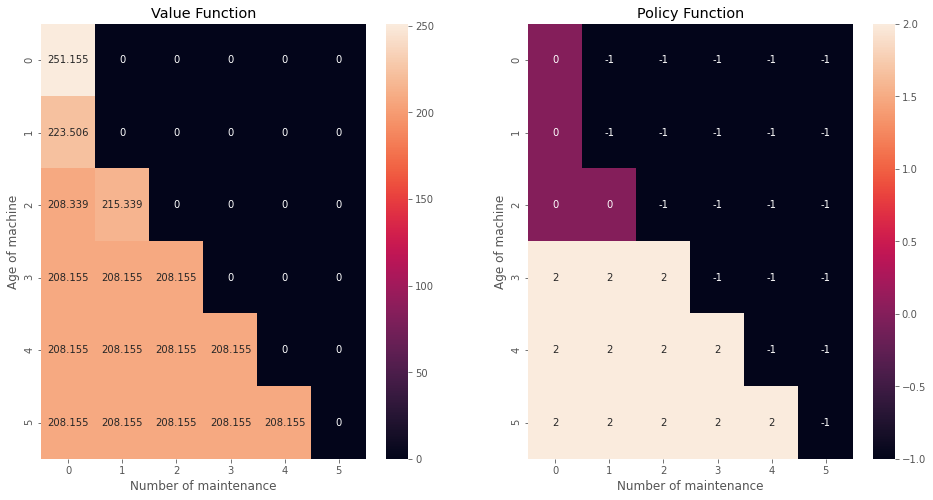

In [3284]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' + str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

In [3285]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 30

# discount factor
discount = 0.9

# apply policy iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 113


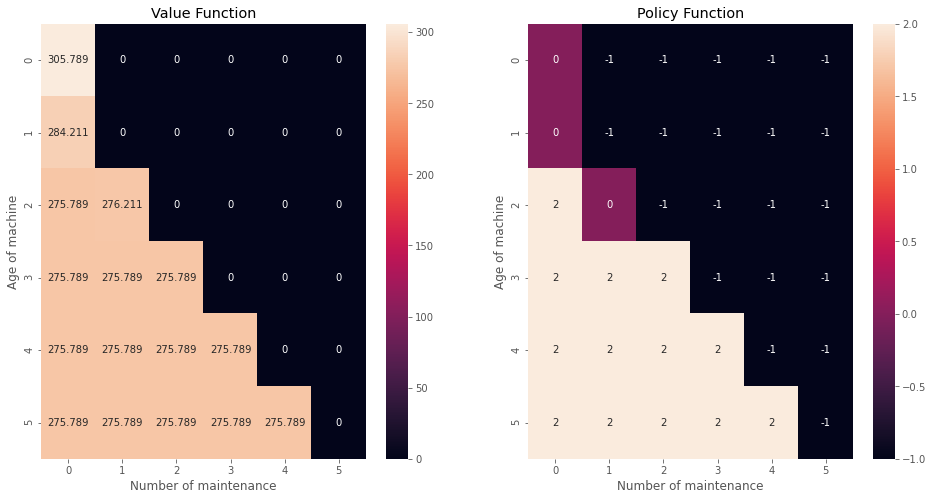

In [3286]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' + str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

In [3287]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 14

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 115


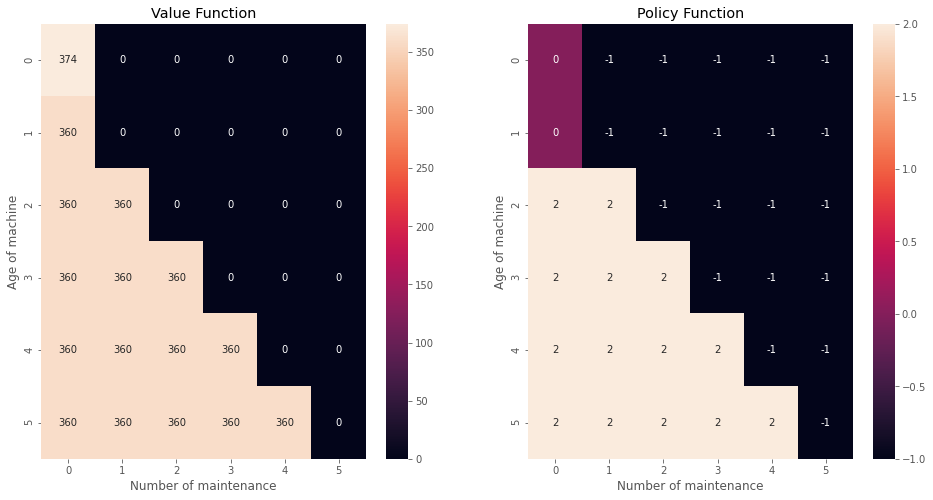

In [3288]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' +str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

In [3289]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# Asset replacement cost
env.cost = 10

# discount factor
discount = 0.9

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 215


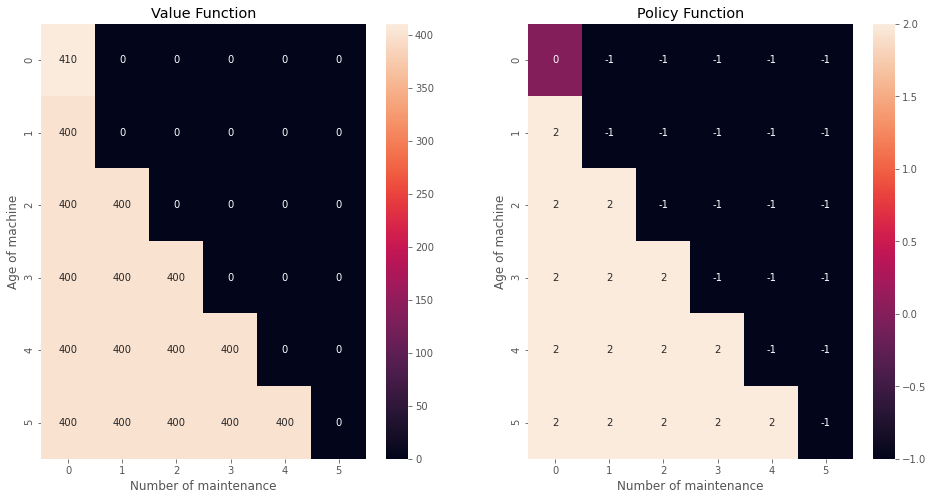

In [3253]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+ '-' + str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

At the end, lets see the plot that quite different from the one derived by the original project task. With maintenance cost as 4, replacement cost as 80 and  future discount as 0.7.

In [3290]:
# create environment and reset it
env = AssetReplacementEnv()
env.reset()
# maintenace cost
env.service = 3
# Asset replacement cost
env.cost = 80


# discount factor
discount = 0.7

# apply value iteration
V, policy = value_iteration(env, discount)

Convergence at iteration: 47


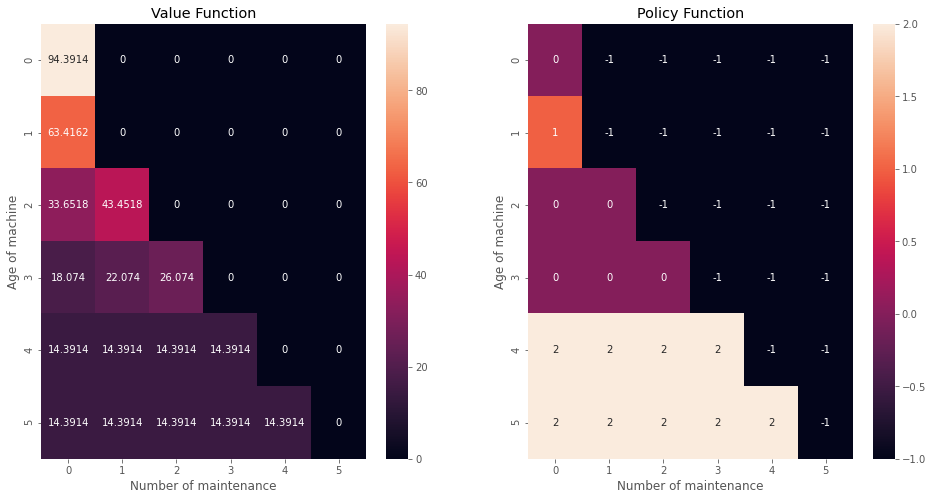

In [3291]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# plot value function
sns.heatmap(V, annot=True, fmt = 'g', ax = ax[0])
ax[0].set_ylabel('Age of machine')
ax[0].set_xlabel('Number of maintenance')
ax[0].set_title('Value Function')

# plot policy function
sns.heatmap(policy, annot=True, ax = ax[1])
ax[1].set_ylabel('Age of machine')
ax[1].set_xlabel('Number of maintenance')
ax[1].set_title('Policy Function')

plt.savefig('DP_VPolicy' + '-' + str(discount)+'-' +str(env.service)+'-' +str(env.cost)+'.pdf')
plt.show()

<a name='RL'></a>

# Reinforcement Learning

<a name='Sarsa'></a>

## **Sarsa Agent**

In [55]:
class SarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        
        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))         
       
    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            reward(float): reward from previous step
            state(int):  current state from the environment
            maint(int):  current sumber of maintenance from environment 
        Returns:
            action(int): next action the agent takes 
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

        # Qt-1 = Qt-1 + step_size( (Rt + discount* Qt) - Qt-1)  
        target = reward + self.discount*self.q[state, maint][action]
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error
            

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

    def step_v(self, reward, state, maint, rate):
        """A step taken by the agent specially when appling vairable step_size
        Args:
            reward(float): reward from previous step
            state(int):  current state from the environment
            maint(int):  current number of maintenance from environment 
        Returns:
            action(int): next action the agent takes 
        """
        if self.step_size > 0.05:
             self.step_size = rate* self.step_size
        
        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)

        # Qt-1 = Qt-1 + step_size( (Rt + discount* Qt) - Qt-1)  
        target = reward + self.discount*self.q[state, maint][action]
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error
            

        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action
        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy.

        Args:
            state (int): Current state, i.e. age of asset.
            maint(int):  current number of maintenance 
        Returns:
            action (int): Action the agent takes.
        """

        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
 #%%%%
        if state== 5:                           # two expression are actually equivalent  
            return 2
        if state == 0:
            return 0
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(env.n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action
        
 
    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """
        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)
#         print(ties)
#         print("argmax index:" + str(index))
        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): intial numebr of maintenance 
        Returns:
            action (int): initial action
        """
        # we shall do nothing at year 0, just keep it without maintenance
        action = 0

        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action
    




Remark: run the cell bellow with certain parameter setting, you might not get exactly the same  performance as shown in the table(pandas dataframe) below in the evaluation section, since the performance vary, like for training with low n_episode, the performance might vary within 20-30 then the variation become smaller for training with high n_episode. We actually got the results in the table by runing the cell below within the loop and then take the average performance.

In [3121]:
env = AssetReplacementEnv()

epsilon = 0.1
step_size = 0.3
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)    
    for t in range(timesteps):
        #mu based on previous states, since reward/profit is calculated by previous state
        # now states are overwritten by current states, reward is caculated based on previous action and states
        mu = (state - maint)/5
        state_next, maint_next, reward = env.step(action)
        
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass
        state = state_next
        maint = maint_next
        # agent return new action    
        action = agent.step(reward, state_next, maint_next)

        
#     print('Episodes-'+ str(i)+'-Q value')
#     print(agent.q)    

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_sar = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_sar[k[0],k[1]] = v
norm = np.linalg.norm(V_sar-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:80.9667614022423


<a name='Eval2'></a>


---

### **Evaluation of parameters**


---


Performance = euclidean norm of difference between value function of dynamic programming(the real one) and Sarsa(the one approximating by sampling), the less the value of the performance, the better is the performance.

Summary:   the step_size is fixed
- $\epsilon$ (greey for action selection)   
  Around 0.1 is the best,  for trends seeing  the table below   
- step_size  the quantity that allowing learning from td_error  
  Around 0.3 is the best, for trends seeing  the table below  
- n_episodes  number of episodes for training  
  theoritically the larger the better, but the performance can't be improve at a maximal n_episodes = 10000.
 

Summary:   the step_size is adaptive
- this seems not really to make much difference on the performance and we don't have enough time to playing around with all combinations of paremeters and decreasing rate of the step_size, so the discussion is omitted here.

In [2759]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'episode': [n_episodes],
                'performance': [norm]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','episode','performance'])
df_parper

,epsilon,step_size,episode,performance
0,0.1,0.3,50000,73.330389


In [2126]:
#df_parper_all = df_parper

In [2149]:
df_parper_all = df_parper_all.append(df_parper,ignore_index=True)

In [2150]:
df_parper_all

,epsilon,step_size,episode,performance
0,0.05,0.2,10000,88.413468
1,0.10,0.2,10000,86.604483
2,0.20,0.2,10000,101.199452
3,0.30,0.2,10000,134.529905
4,0.02,0.2,10000,123.757342
5,0.15,0.2,10000,100.033196


In [2179]:
df_stepsize = df_parper

In [2156]:
#df_stepsize_all = df_stepsize

In [2180]:
df_stepsize_all = df_stepsize_all.append(df_stepsize,ignore_index=True)

In [2189]:
df_stepsize_all

,epsilon,step_size,episode,performance
0,0.1,0.1,10000,97.554134
1,0.1,0.2,10000,83.290299
2,0.1,0.3,10000,77.156078
3,0.1,0.4,10000,104.443686
4,0.1,0.5,10000,110.504292
5,0.1,0.6,10000,130.068787


In [2760]:
df_episode = df_parper

In [2715]:
#df_episode_all = df_episode

In [2761]:
df_episode_all = df_episode_all.append(df_episode,ignore_index=True)


In [2762]:
df_episode_all 

,epsilon,step_size,episode,performance
0,0.1,0.3,1000,122.862970
1,0.1,0.3,2000,110.346370
2,0.1,0.3,5000,99.881284
3,0.1,0.3,10000,73.293087
4,0.1,0.3,20000,73.254168
5,0.1,0.3,50000,73.330389


<a name='plot1'></a>


---

### **Plot one simulation of best performance**


---


The variable $fail$ indicates that asset failed/succeed (fail = 1/0) and the asset was replaced(fail = -1), because we don't consider of the failure in this case, where mu = (0-0)/5 = 0 absolutely surely in this case.

In [3122]:
# Perform path simulation of episode:  n_episode+1
state, maint = env.reset()
action = agent.start(state, maint)
# when training, we allow the exploration to some extent, but take the greddy one here so that 
# we won't have abnormal(randomly chosen) action in simulation.
agent.epsilon = 0
state_path = [state]
maint_path = [maint]
action_path = [action]
fail_path = []
for t in range(timesteps):
    mu = (state - maint)/5
    state, maint,reward = env.step(action)
    if action == 2:
        fail = -1
    elif action ==1:
        if env.rng.random() < mu:
            reward = 0 - env.service
            fail = 1
        else:
            fail = 0
    else:
        if env.rng.random() < mu:
            reward = 0
            fail = 1
        else:
            fail = 0
    action = agent.step(reward, state, maint)
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)
    fail_path.append(fail)

In [3123]:
# extract the value function from action value function 
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action


In [3124]:
#convert dictionary to array so that we can compare the norm of different value function
V_sar = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_sar[k[0],k[1]] = v
norm = np.linalg.norm(V_sar-V_DP)
norm

79.7131859417786

In [3125]:
action_path

[0, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 2]

In [3126]:
fail_path

[0, 0, 0, 1, -1, 1, 0, 0, -1, 0, 1, 0, -1, 0, 0, 1, -1, 0, 0, 0]

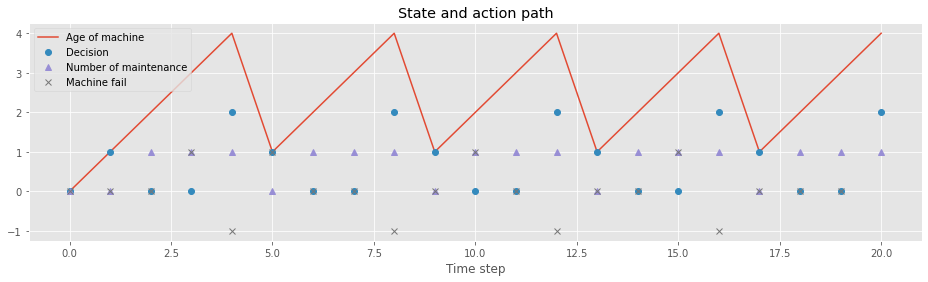

In [3127]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenance')
plt.plot(fail_path, 'x', label='Machine fail')
plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('SARSA_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

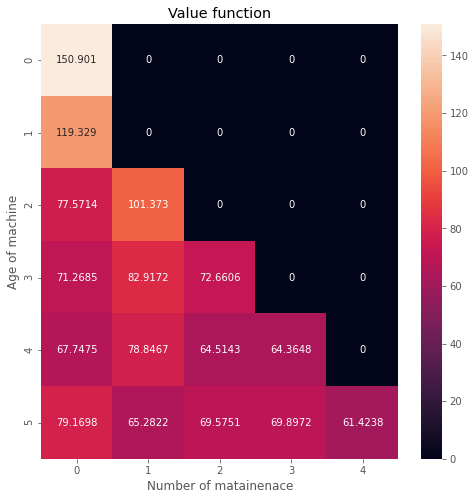

In [3128]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Number of matainenace"]))
df = ser.unstack().fillna(0)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Value function')
plt.savefig('SARSA_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

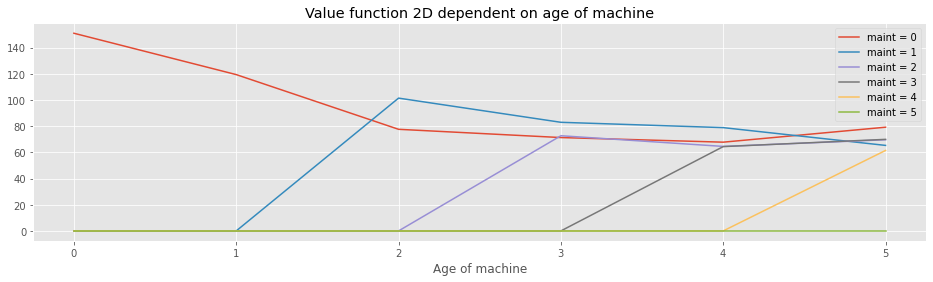

In [3137]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_sar[:, 0], label='maint = 0')
plt.plot(V_sar[:, 1], label='maint = 1')
plt.plot(V_sar[:, 2], label='maint = 2')
plt.plot(V_sar[:, 3], label='maint = 3')
plt.plot(V_sar[:, 4], label='maint = 4')
plt.plot(V_sar[:, 5], label='maint = 5')
plt.title('Value function 2D dependent on age of machine')
plt.xlabel('Age of machine')
plt.legend()
plt.savefig('SARSA_Q_2D(year)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

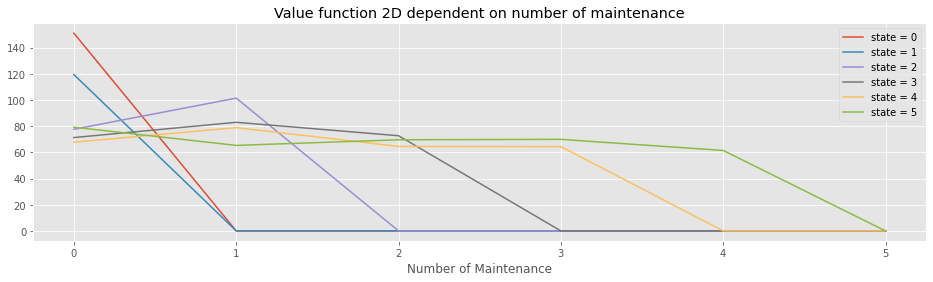

In [3138]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_sar[0, :], label='state = 0')
plt.plot(V_sar[1, :], label='state = 1')
plt.plot(V_sar[2, :], label='state = 2')
plt.plot(V_sar[3, :], label='state = 3')
plt.plot(V_sar[4, :], label='state = 4')
plt.plot(V_sar[5, :], label='state = 5')
plt.title('Value function 2D dependent on number of maintenance')
plt.xlabel('Number of Maintenance')
plt.legend()
plt.savefig('SARSA_Q_2D(maint)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

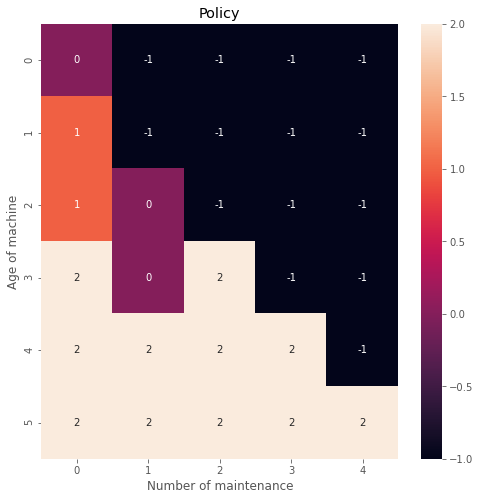

In [3129]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Number of maintenance"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Policy')
plt.savefig('SARSA_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

variable stepsize

In [51]:
env = AssetReplacementEnv()

epsilon = 0.1
step_size = 0.4
discount = 0.9
rate = 0.95

agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)    
    for t in range(timesteps):
        #mu based on previous states, since reward/profit is calculated by previous state
        # now states are overwritten by current states, reward is caculated based on previous action and states
        mu = (state - maint)/5
        state_next, maint_next, reward, = env.step(action)
        
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass
        state = state_next
        maint = maint_next
        # agent return new action    
        action = agent.step_v(reward, state_next, maint_next, rate)

        
#     print('Episodes-'+ str(i)+'-Q value')
#     print(agent.q)    

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_sar = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_sar[k[0],k[1]] = v
norm = np.linalg.norm(V_sar-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:92.36977182016881


variable epsilon for epsilon greedy

In [49]:
env = AssetReplacementEnv()

epsilon = 0.1
step_size = 0.3
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)
    for t in range(timesteps):
        agent.epsilon = 1/ (t + 0.001)
        #mu based on previous states, since reward/profit is calculated by previous state
        # now states are overwritten by current states, reward is caculated based on previous action and states
        mu = (state - maint)/5
        state_next, maint_next, reward, = env.step(action)
        
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass
        state = state_next
        maint = maint_next
        # agent return new action    
        action = agent.step(reward, state_next, maint_next)

        
#     print('Episodes-'+ str(i)+'-Q value')
#     print(agent.q)    

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_sar = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_sar[k[0],k[1]] = v
norm = np.linalg.norm(V_sar-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:97.37243367536983


<a name='QL'></a>

## **Q-Learning Agent**

In [57]:
class QLearningAgent():
    def __init__(self, agent_info):
        """Initialize Agent

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """
        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))      


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            reward(float): reward got from previous step
            state (int):  next state from the environment
            maint (int):  next state of maintenance failure from environment 
        Returns:
            action (int): action the agent takes in next_state
        """    
        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)
        target = reward + self.discount*np.max(self.q[state, maint])   
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error


        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action
    
    def step_v(self, reward, state, maint, rate):
        """A step taken by the agent for vatiable step_size

        Args:
            reward(float): reward got from previous step
            state (int):  next state from the environment
            maint (int):  next state of maintenance failure from environment 
        Returns:
            action (int): action the agent takes in next_state
        """
        if self.step_size > 0.05:
            self.step_size = rate*self.step_size
        
        # choose action using epsilon greedy policy
        action = self.select_action(state, maint)
        target = reward + self.discount*np.max(self.q[state, maint])   
        td_error = target - self.q[self.previous_state,self.previous_maint][self.previous_action]
        self.q[self.previous_state,self.previous_maint][self.previous_action] += self.step_size* td_error


        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action 
    
    

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        
        # performe epsilon greedy policy improvement
        # remember to replace asset if age is 5
        if state== 5:
            return 2
        
        if  self.rng.random() < self.epsilon:
            action = self.rng.choice(env.n_actions)
        else:
            action = self.argmax(self.q[state, maint])
        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = 0

        self.previous_maint= maint
        self.previous_state = state
        self.previous_action = action

        return action


Remark: run the cell bellow with certain parameter setting, you might not get exactly the same  performance as shown in the table(pandas dataframe) below in the evaluation section, since the performance vary, like for training with low n_episode, the performance might vary within 20-30 then the variation become smaller for training with high n_episode, like vary within 5.
But still, we actually got the results in the table by runing the cell below within the loop and then take the average performance especially when it is with poor parameter settings.

In [39]:
env = AssetReplacementEnv()

epsilon = 0.3
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        mu = (state - maint)/5
        state, maint, reward, = env.step(action)
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass    
        action = agent.step(reward, state, maint)

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_QL = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_QL[k[0],k[1]] = v
norm = np.linalg.norm(V_QL-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:20.6247046394337


<a name ='Eval3'></a>


---

### **Evaluation of parameters**


---

Summary:  
- perform much better than Sarsa.
- $\epsilon$ (greey for action selection)   
  Around 0.2 - 0.4 is the best, when n_episodes=10000 for trends seeing  the table below   
- step_size  the quantity that allowing learning from td_error  
  Around 0.3 is the best, for trends seeing  the table below  
- n_episodes  number of episodes for training  
  theoritically the larger the better, but the performance can't be improve significantly after n_episodes = 10000.

In [2604]:
import pandas as pd
param_perform = {'epsilon': [epsilon],
                'step_size': [step_size],
                'episode': [n_episodes],
                'performance': [norm]}
df_parper = pd.DataFrame (param_perform, columns = ['epsilon','step_size','episode','performance'])
df_parper

,epsilon,step_size,episode,performance
0,0.3,0.2,10000,12.831107


In [2535]:
df_epsilon = df_parper

In [2480]:
#df_epsilon_all = df_epsilon

In [2536]:
df_epsilon_all = df_epsilon_all.append(df_epsilon, ignore_index = True)

In [2537]:
df_epsilon_all

,epsilon,step_size,episode,performance
0,0.05,0.2,10000,86.224117
1,0.10,0.2,10000,61.988011
2,0.20,0.2,10000,18.846730
3,0.30,0.2,10000,19.517578
4,0.40,0.2,10000,20.558828
5,0.50,0.2,10000,24.219477
6,0.60,0.2,10000,25.391839
7,0.70,0.2,10000,35.083876
8,0.80,0.2,10000,38.960041


In [2566]:
df_stepsize = df_parper


In [2541]:
#df_stepsize_all = df_stepsize

In [2567]:
df_stepsize_all =  df_stepsize_all.append(df_stepsize,ignore_index=True)
df_stepsize_all

,epsilon,step_size,episode,performance
0,0.3,0.05,10000,25.268998
1,0.3,0.10,10000,13.257339
2,0.3,0.20,10000,12.419829
3,0.3,0.20,10000,18.885340
4,0.3,0.30,10000,25.108683
5,0.3,0.40,10000,24.478720
6,0.3,0.50,10000,27.698123


In [2600]:
df_episode = df_parper

In [2571]:
#df_episode_all = df_episode

In [2601]:
df_episode_all = df_episode_all.append(df_episode,ignore_index=True)


In [2602]:
df_episode_all

,epsilon,step_size,episode,performance
0,0.3,0.2,1000,45.837908
1,0.3,0.2,2000,29.726903
2,0.3,0.2,5000,24.666820
3,0.3,0.2,10000,18.056475
4,0.3,0.2,20000,18.283516
5,0.3,0.2,50000,19.275222
6,0.3,0.2,50000,19.275222


<a name ='plot2'></a>


---

### **Plot one simulation of best performance**


---


The variable $fail$ indicates that asset failed/succeed (fail = 1/0) and the asset was replaced(fail = -1), because we don't consider of the failure in this case, where mu = (0-0)/5 = 0 absolutely surely in this case.

In [69]:
# Perform path simulation
state, maint = env.reset()
#same as above to avoid randomly chose action resulted from exploration
agent.epsilon = 0
action = agent.start(state, maint)

state_path = [state]
maint_path = [maint]
action_path = [action]
fail_path = []

timesteps = 20

for t in range(timesteps):
    mu = (state - maint)/5
    state, maint,reward = env.step(action)
    if action == 2:
        fail = -1
    elif action ==1:
        if env.rng.random() < mu:
            reward = 0 - env.service
            fail = 1
        else:
            fail = 0
    else:
        if env.rng.random() < mu:
            reward = 0
            fail = 1
        else:
            fail = 0
    action = agent.step(reward, state, maint)
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)
    fail_path.append(fail)

In [70]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    action = np.argmax(values)
    policy[state_maint] = action
    V[state_maint] = value


In [71]:
V_QL = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_QL[k[0],k[1]] = v
np.linalg.norm(V_QL-V_DP)

21.05027909166157

In [76]:
action_path

[0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0]

In [77]:
fail_path

[0, 0, 0, -1, 0, 0, -1, 0, 0, -1, 1, 0, -1, 0, 1, -1, 0, 0, -1, 0]

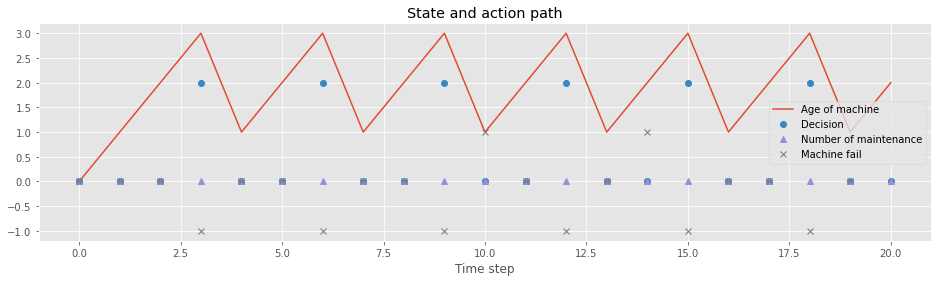

In [78]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenance')
plt.plot(fail_path, 'x', label='Machine fail')

plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('QLearning_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


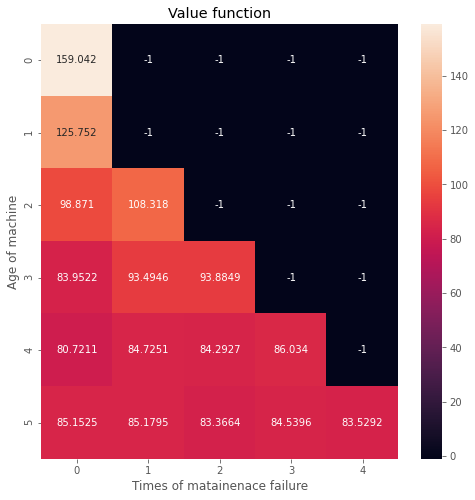

In [79]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Value function')
plt.savefig('Qlearning_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

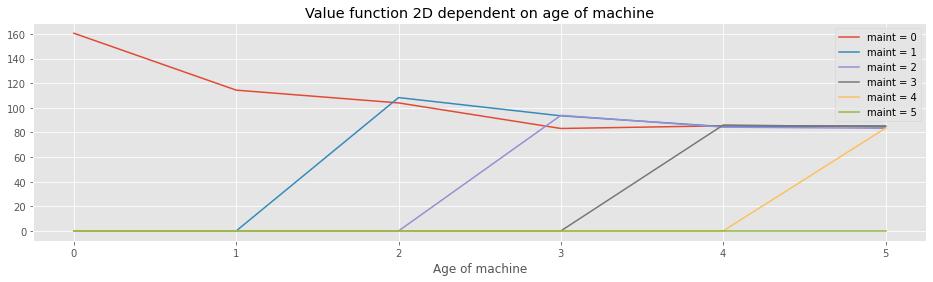

In [60]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_QL[:, 0], label='maint = 0')
plt.plot(V_QL[:, 1], label='maint = 1')
plt.plot(V_QL[:, 2], label='maint = 2')
plt.plot(V_QL[:, 3], label='maint = 3')
plt.plot(V_QL[:, 4], label='maint = 4')
plt.plot(V_QL[:, 5], label='maint = 5')
plt.title('Value function 2D dependent on age of machine')
plt.xlabel('Age of machine')
plt.legend()
plt.savefig('QLearning_Q_2D(year)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

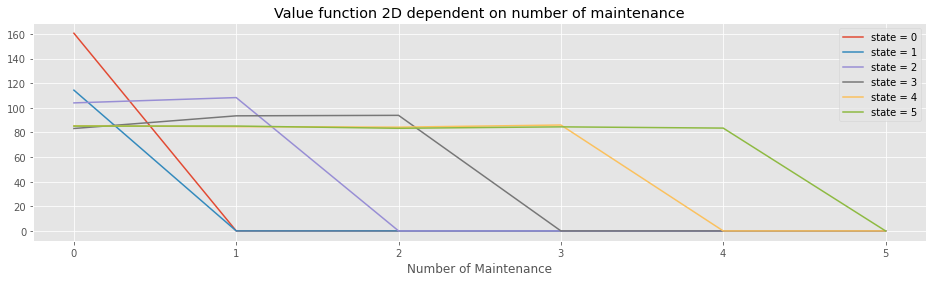

In [61]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_QL[0, :], label='state = 0')
plt.plot(V_QL[1, :], label='state = 1')
plt.plot(V_QL[2, :], label='state = 2')
plt.plot(V_QL[3, :], label='state = 3')
plt.plot(V_QL[4, :], label='state = 4')
plt.plot(V_QL[5, :], label='state = 5')
plt.title('Value function 2D dependent on number of maintenance')
plt.xlabel('Number of Maintenance')
plt.legend()
plt.savefig('QLearning_Q_2D(maint)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

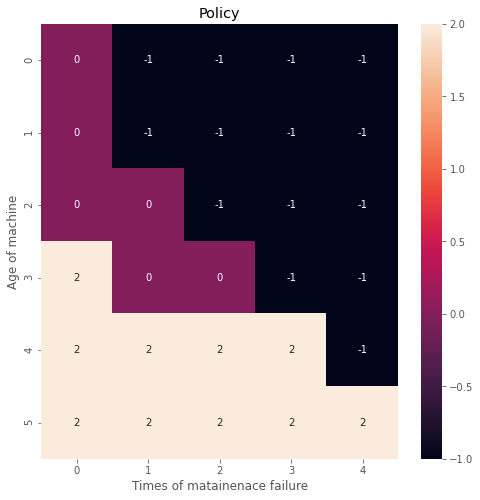

In [80]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Times of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.title('Policy')
plt.savefig('Qlearning_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

<a name='ExSa'></a>

variable stepsize

In [24]:
env = AssetReplacementEnv()

epsilon = 0.3
step_size = 0.4
discount = 0.9
rate = 0.9

agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        mu = (state - maint)/5
        state, maint, reward, = env.step(action)
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass     
        action = agent.step_v(reward, state, maint, rate)

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_QL = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_QL[k[0],k[1]] = v
norm = np.linalg.norm(V_QL-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:27.55430231012087


variable epsilon for epsilon greedy

In [52]:

env = AssetReplacementEnv()

epsilon = 0.3
step_size = 0.2
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)

n_episodes = 10000
timesteps = 20

for i in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)
    for t in range(timesteps):
        agent.epsilon = 1/(t + 0.001)
        mu = (state - maint)/5
        state, maint, reward, = env.step(action)
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass     
        action = agent.step(reward, state, maint)

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_QL = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_QL[k[0],k[1]] = v
norm = np.linalg.norm(V_QL-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))

Norm of difference of value function at episodes10000 simulation:19.389366460468068


## **Expected Sarsa**

In [3198]:
class ExpectedSarsaAgent():
    def __init__(self, agent_info):
        """Initialize Agent.

        Args: 
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))        


    def step(self, reward, state, maint):
        """A step taken by the agent

        Args:
            state (int):  next state from the environment
            maint (int):  next state of maintenance failure from environment 
        Returns:
            action (int): action the agent takes in next_state
        """

         # choose action using epsilon greedy policy
        action = self.select_action(state, maint)  

        # perform update
        policy = np.ones(self.n_actions)*self.epsilon/self.n_actions
        policy[np.argmax(self.q[state, maint])] += 1 - self.epsilon

       # matrix-vector multiplication
        expectation = self.q[state, maint] @ policy
        target = reward + self.discount * expectation
        td_error = target - self.q[self.previous_state, self.previous_maint][self.previous_action]
        self.q[self.previous_state, self.previous_maint][self.previous_action] += self.step_size * td_error



        # save current state and action
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

        
    def select_action(self, state, maint):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state
            maint (int): current times of maitenance failure
        Returns:
            action (int): action the agent takes
        """
        if state == 5 or maint == 4:
            return 2

        current_q  = self.q[state, maint]
      
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(self.n_actions)
        else:
            action = self.argmax(current_q)

        return action
        

    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state, maint):
        """Selects action in inital state

        Args:
            state (int): initial state
            maint (int): initial maint
        Returns:
            action (int): initial action
        """

        action = 0
        self.previous_state = state
        self.previous_maint = maint
        self.previous_action = action

        return action

In [3199]:
env = AssetReplacementEnv()

epsilon = 0.1
step_size = 0.3
discount = 0.9


agent_info = {"n_actions": env.n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = ExpectedSarsaAgent(agent_info)


n_episodes = 10000
timesteps = 20

for _ in range(n_episodes):
    state, maint = env.reset()
    action = agent.start(state, maint)

    for t in range(timesteps):
        mu = (state - maint)/5
        state, maint, reward, = env.step(action)
        if action == 2:
            pass
        elif action ==1:
            if env.rng.random() < mu:
                reward = 0 - env.service
            else:
                pass
        else:
            if env.rng.random() < mu:
                reward = 0
            else:
                pass    
        action = agent.step(reward, state, maint)

V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action



#convert dictionary to array so that we can compare the norm of different value function
V_Ex = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_Ex[k[0],k[1]] = v
norm = np.linalg.norm(V_Ex-V_DP)
print('Norm of difference of value function at episodes'+ str(n_episodes)+' simulation:' + str(norm))


Norm of difference of value function at episodes10000 simulation:64.99337011965478


<a name ='plot3'></a>


---

### **Plot one simulation of best performance**


---



The variable $fail$ indicates that asset failed (fail = 1) and the asset was replaced(fail = -1), thus we don't consider of the failure, since mu = (0-0)/5 = 0 absolutely surely in this case.

In [3200]:
# Perform path simulation
state, maint = env.reset()
action = agent.start(state, maint)
agent.epsilon =0

state_path = [state]
maint_path = [maint]
action_path = [action]
fail_path = []

timesteps = 20

for t in range(timesteps):
    mu = (state - maint)/5
    state, maint,reward = env.step(action)
    if action == 2:
        fail = -1
    elif action ==1:
        if env.rng.random() < mu:
            reward = 0 - env.service
            fail = 1
        else:
            fail = 0
    else:
        if env.rng.random() < mu:
            reward = 0
            fail = 1
        else:
            fail = 0
    action = agent.step(reward, state, maint)
    state_path.append(state)
    maint_path.append(maint)
    action_path.append(action)
    fail_path.append(fail)

In [3201]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state_maint, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state_maint] = value
    action = np.argmax(values)
    policy[state_maint] = action
    

In [3202]:
V_Ex = np.zeros((env.n_states, env.n_maint))
for k, v in V.items():
    V_Ex[k[0],k[1]] = v
np.linalg.norm(V_Ex-V_DP)

67.33884449268973

In [3203]:
action_path

[0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0]

In [3204]:
fail_path

[0, 0, 1, -1, 0, 0, -1, 1, 0, -1, 0, 1, -1, 1, 0, -1, 1, 0, -1, 0]

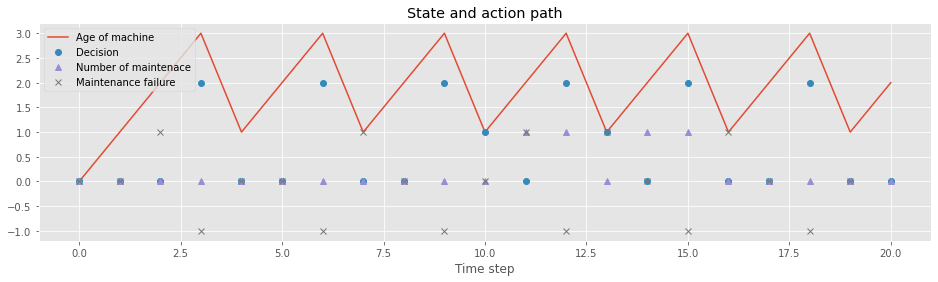

In [3205]:
fig = plt.figure(figsize=(16, 4))
plt.plot(state_path, label='Age of machine')
plt.plot(action_path, 'o', label='Decision')
plt.plot(maint_path, '^', label='Number of maintenace')
plt.plot(fail_path, 'x', label='Maintenance failure')

plt.title('State and action path')
plt.xlabel('Time step')
plt.legend()
plt.savefig('ExSarsa_Path' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()


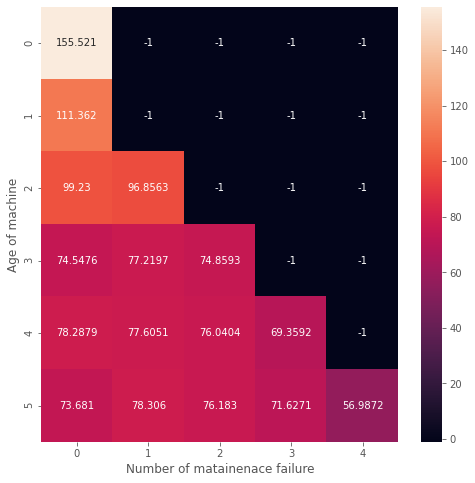

In [3206]:

plt.figure(figsize=(8,8))
ser = pd.Series(list(V.values()),
                  index= pd.MultiIndex.from_tuples( V.keys(), names=["Age of machine", "Number of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Q' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

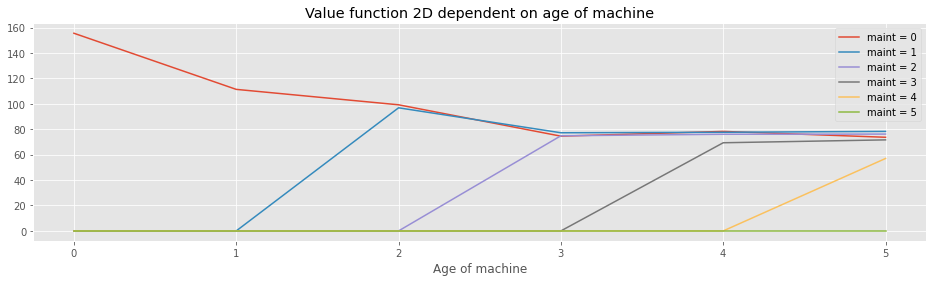

In [3208]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_Ex[:, 0], label='maint = 0')
plt.plot(V_Ex[:, 1], label='maint = 1')
plt.plot(V_Ex[:, 2], label='maint = 2')
plt.plot(V_Ex[:, 3], label='maint = 3')
plt.plot(V_Ex[:, 4], label='maint = 4')
plt.plot(V_Ex[:, 5], label='maint = 5')
plt.title('Value function 2D dependent on age of machine')
plt.xlabel('Age of machine')
plt.legend()
plt.savefig('ExSa_Q_2D(year)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

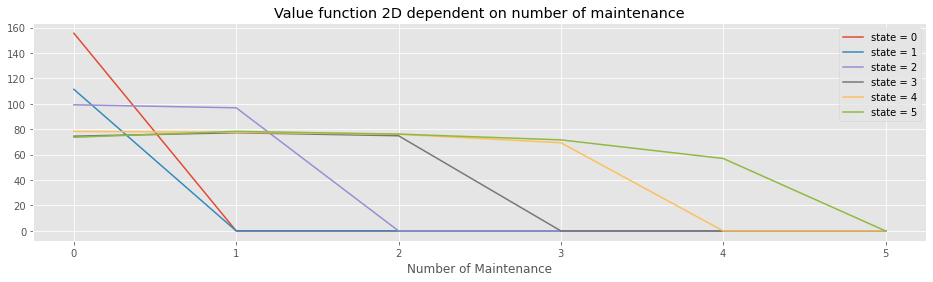

In [3209]:
fig = plt.figure(figsize=(16, 4))
plt.plot(V_Ex[0, :], label='state = 0')
plt.plot(V_Ex[1, :], label='state = 1')
plt.plot(V_Ex[2, :], label='state = 2')
plt.plot(V_Ex[3, :], label='state = 3')
plt.plot(V_Ex[4, :], label='state = 4')
plt.plot(V_Ex[5, :], label='state = 5')
plt.title('Value function 2D dependent on number of maintenance')
plt.xlabel('Number of Maintenance')
plt.legend()
plt.savefig('ExSa_Q_2D(maint)' + '-'+ str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

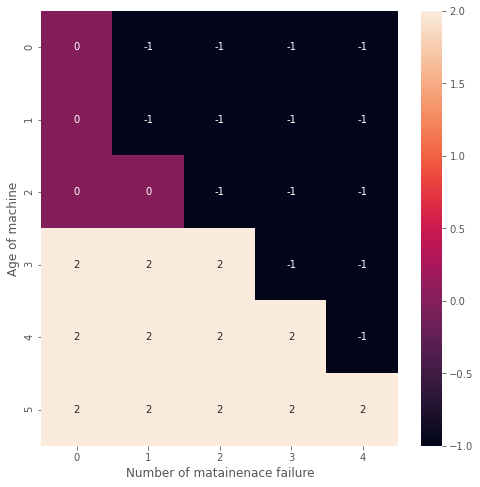

In [3210]:
plt.figure(figsize=(8,8))
ser = pd.Series(list(policy.values()),
                  index= pd.MultiIndex.from_tuples( policy.keys(), names=["Age of machine", "Number of matainenace failure"]))
df = ser.unstack().fillna(-1)
#df.shape
sns.heatmap(df, annot=True, fmt = 'g')
plt.savefig('ExSarsa_Policy' +'-' +str(n_episodes)+'-' + str(discount)+'-'+ str(step_size)+'-'+ str(epsilon) +'.pdf')
plt.show()

<a name='conclusion'></a>

# Conclusion

Best performace rounded as integer, detail see section for each agent.  n_episodes = 10000, increasing the episodes won't improved much, well little bit. Consider of the variation it can even be little bit worse.  $\epsilon$ (greey for action selection) and step_size see below.  

Performance:
- Sarsa:    about 73;   $\epsilon$: 0.1, step_size:0.3    
- Qlearning: about 18; $\epsilon$: 0.3,step_size: 0.2      
- ExSarsa:  about 66;  $\epsilon$:0.1, step_size: 0.3     

        
Qlearning perform much better than Sarsa, where ExSarsa is slightly better than Sarsa.    

Sarsa need to be more carefully tuned regarding the epsilon for epsilon greedy to controll the how much exploration can be tolerated.
Sarsa perform conservatively and would choose not to be greedy to avoid the possible risk resulting in nagative reward at next step. 
Furthermore, it is known that Q-Learning  have higher per-sample variance, thus is harder to converge. 